In [29]:
import pandas as pd
import pandas_profiling
import os
import pickle
import gc
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

#データ読み込み
train = pd.read_csv("data_EDA/train.csv")
test = pd.read_csv("data_EDA/test.csv")

In [30]:
train.head()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
0,200,9,125,74,0,0,28.536910,0.444902,45,1.0,...,0,0.200000,26.875,74.0,135.636364,3-,0,0,0,1
1,3832,4,109,80,0,0,28.047673,0.238243,22,0.0,...,0,0.181818,26.875,80.0,135.636364,-3,0,0,1,0
2,4927,4,88,78,39,0,52.371341,0.279471,26,0.0,...,0,0.153846,39.000,78.0,135.636364,-3,0,0,1,0
3,4088,9,125,74,0,0,40.062688,0.203922,45,0.0,...,0,0.200000,26.875,74.0,135.636364,3-,0,0,0,1
4,3644,5,107,78,44,284,52.935068,0.284959,45,1.0,...,0,0.111111,44.000,78.0,284.000000,-3,0,0,1,0


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     3000 non-null   int64  
 1   Pregnancies               3000 non-null   int64  
 2   Glucose                   3000 non-null   int64  
 3   BloodPressure             3000 non-null   int64  
 4   SkinThickness             3000 non-null   int64  
 5   Insulin                   3000 non-null   int64  
 6   BMI                       3000 non-null   float64
 7   DiabetesPedigreeFunction  3000 non-null   float64
 8   Age                       3000 non-null   int64  
 9   Outcome                   3000 non-null   float64
 10  BloodPressure_0           2887 non-null   float64
 11  SkinThickness_0           1234 non-null   float64
 12  Insulin_0                 256 non-null    float64
 13  Pregnancies_0             2570 non-null   float64
 14  SkinThic

In [32]:
train.describe()

,index,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,...,Insulin_na,Pregnancies_na,Pre/age,SkinThickness_mean,BloodPressure_mean,Insulin_dpf_mean,Pregnancies_bin_0,Pregnancies_bin_-1,Pregnancies_bin_-3,Pregnancies_bin_3-
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000
mean,2492.964667,3.557000,113.733667,68.743667,11.164000,11.663333,35.408959,0.400476,28.932000,0.239000,...,0.914667,0.037667,0.120089,26.984417,71.433414,135.725394,0.143333,0.330667,0.272000,0.25400
std,1447.218078,3.032131,20.885612,16.332755,14.351159,45.064090,6.990180,0.274666,8.469078,0.426544,...,0.279424,0.190421,0.100340,5.248441,9.040411,23.922032,0.350471,0.470532,0.445064,0.43537
min,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000,7.748040,0.145844,21.000000,0.000000,...,0.000000,0.000000,0.000000,7.000000,46.000000,15.000000,0.000000,0.000000,0.000000,0.00000
25%,1218.750000,1.000000,100.000000,64.000000,0.000000,0.000000,32.301920,0.230987,22.000000,0.000000,...,1.000000,0.000000,0.045455,26.875000,64.000000,135.636364,0.000000,0.000000,0.000000,0.00000
50%,2465.500000,3.000000,111.000000,70.000000,0.000000,0.000000,33.835873,0.268674,26.000000,0.000000,...,1.000000,0.000000,0.098780,26.875000,71.409223,135.636364,0.000000,0.000000,0.000000,0.00000
75%,3750.250000,6.000000,125.000000,78.000000,24.000000,0.000000,39.578256,0.506778,33.000000,0.000000,...,1.000000,0.000000,0.172414,26.875000,78.000000,135.636364,0.000000,1.000000,1.000000,1.00000
max,4999.000000,13.000000,196.000000,110.000000,49.000000,579.000000,53.400629,2.302072,67.000000,1.000000,...,1.000000,1.000000,0.619048,49.000000,110.000000,579.000000,1.000000,1.000000,1.000000,1.00000


In [36]:
train[['Pregnancies_bin']] = train[['Pregnancies_bin']].astype("category")
test[['Pregnancies_bin']] = test[['Pregnancies_bin']].astype("category")

In [37]:
# まずは少ない特徴量から検討していく
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'Pregnancies_bin',
                 
                 'BloodPressure_0', 
                 'SkinThickness',
                 'Insulin_0',
                 'Insulin_na',
                 
                 
                ]]
id_train = train[['index']]
y_train = train[['Outcome']]


X_test = test[X_train.columns]
id_test = test[id_train.columns]

In [38]:
print(X_train.shape, y_train.shape, id_train.shape)

(3000, 10) (3000, 1) (3000, 1)


ベースライン評価のため一部データを分ける。

残りのデータでvalidationしてその条件・目的変数・validation方法・評価指標を仮定し評価する。

上記3項目を明確にすることをベースラインの決定とする。

validationした後にベースライン評価のためのデータで評価しベースラインを検証する。

validation時とベースライン検証時の結果の傾向に大きな差が無ければベースラインの3項目は問題ないと判断する。

ベースラインが決定すると、その後EDAやモデル改善後はvalidationのみを行い進めていく。
（変更点や結果を記録）

## validation方法（ベースライン作成へ）

In [39]:
random_state = 123
params = {
    'boosting_type' :'gbdt',
    'objective' : 'binary',
    'metrics' : 'auc',
    'learning_rate' : 0.1,
    'num_leaves': 48,
    'min_data_in_leaf': 126,
    'min_sum_hessian_in_leaf': 6.972104745468846e-05,
    'feature_fraction': 0.591372148877871,
    'bagging_fraction': 0.8492100478235491,
    'reg_alpha': 1.196667720289308,
    'reg_lambda': 0.10114064587525043,
    'random_state' : random_state,
    'importance_type' : 'gain'
    }


In [40]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'metrics': 'auc',
 'learning_rate': 0.1,
 'num_leaves': 48,
 'min_data_in_leaf': 126,
 'min_sum_hessian_in_leaf': 6.972104745468846e-05,
 'feature_fraction': 0.591372148877871,
 'bagging_fraction': 0.8492100478235491,
 'reg_alpha': 1.196667720289308,
 'reg_lambda': 0.10114064587525043,
 'random_state': 123,
 'importance_type': 'gain'}

In [41]:
# cvでの評価用
def train_lgb(input_x,
              input_y,
              input_id,
              params,
              list_nfold=[0,1,2,3,4],
              n_splits=5,
              random_state=123
            ):
    train_oof = np.zeros(len(input_x))
    # foldごとの推論値
    metrics = []
    imp = pd.DataFrame()
                         
    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state).
              split(input_x, input_y))
    
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print('y_train:{:.3f}, y_tr:{:.3f}, y_va{:.3f}'.
              format(y_train['Outcome'].mean(), y_tr['Outcome'].mean(), y_va['Outcome'].mean(),))

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr,y_tr),(x_va,y_va)],
                  early_stopping_rounds=100,
                  verbose=100,
                 )
        # モデルの保存
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'wb')as f:
            pickle.dump(model, f, protocol=4)
            
        # 評価
        y_tr_pred = model.predict_proba(x_tr)[:,1]
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_tr = accuracy_score(y_tr, np.where(y_tr_pred>=0.5,1,0).astype(int))
        metric_va = accuracy_score(y_va, np.where(y_va_pred>=0.5,1,0).astype(int))
        print('[accuracy] tr: {:.2f}, va: {:2f}'.
             format(metric_tr, metric_va))
        metrics.append([nfold, metric_tr, metric_va])
        
        # oof
        train_oof[idx_va] = y_va_pred
        
        # imp
        _imp = pd.DataFrame({'col':input_x.columns, 'imp':model.feature_importances_,'nfold':nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=False)

    print('-'*20, 'result', '-'*20)
    
    # metrix出力
    metrics = np.array(metrics)
    print(metrics)
    print('[cv] tr: {:.2f}+-{:.2f}, va: {:.2f}'.format(
        metrics[:,1].mean(), metrics[:,1].std(),
        metrics[:,2].mean(), metrics[:,2].std()
    ))
    print('[oof] {:.4f}'.format(
        accuracy_score(input_y, np.where(train_oof>=0.5,1,0))))
    # oof出力  
    train_oof = pd.concat([
        input_id,
        pd.DataFrame({'pred':train_oof})]
        ,axis=1)
    
    # imp出力
    imp = imp.groupby('col')['imp'].agg(['mean', 'std']).reset_index(drop=False)
    imp.columns = ['col', 'imp', 'imp_std']

    print('Done')
    
    return train_oof, imp, metrics

In [42]:
train_oof, imp, metrics = train_lgb(X_train, y_train, id_train, params,list_nfold=[0,1,2,3,4], n_splits=5, random_state=123)

-------------------- 0 --------------------
(2400, 10) (2400, 1)
(600, 10) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.972104745468846e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.972104745468846e-05
[LightGBM] [Warning] bagging_fraction is set=0.8492100478235491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492100478235491
[LightGBM] [Warning] feature_fraction is set=0.591372148877871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.591372148877871
[100]	training's auc: 0.907545	valid_1's auc: 0.844542
[accuracy] tr: 0.86, va: 0.796667
-------------------- 1 --------------------
(2400, 10) (2400, 1)
(600, 10) (600, 1)
y_train:0.239, y_tr:0.239, y_va0.240
[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20

In [43]:
imp.sort_values('imp', ascending=False)

,col,imp,imp_std
1,BMI,1171.400536,73.006924
0,Age,1079.840312,112.474184
4,Glucose,613.307700,47.589202
8,Pregnancies_bin,489.123744,30.088258
3,DiabetesPedigreeFunction,486.329140,39.610433
2,BloodPressure_0,437.353778,28.813629
7,Pregnancies,349.742895,34.409986
9,SkinThickness,306.551520,42.651564
5,Insulin_0,19.074242,11.592485
6,Insulin_na,5.289590,3.370471


In [44]:
train_oof

,index,pred
0,200,0.589304
1,3832,0.057239
2,4927,0.354875
3,4088,0.615251
4,3644,0.527615
...,...,...
2995,4931,0.485399
2996,3264,0.042984
2997,1653,0.131198
2998,2607,0.243656


###

'DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'BloodPressure_na', 'BloodPressure_0', 'SkinThickness', 'Insulin_0' 'Insulin_na' 
       
       
'SkinThickness_na' or 'SkinThickness'
###

In [45]:
X_train.columns

Index(['DiabetesPedigreeFunction', 'BMI', 'Glucose', 'Age', 'Pregnancies',
       'Pregnancies_bin', 'BloodPressure_0', 'SkinThickness', 'Insulin_0',
       'Insulin_na'],
      dtype='object')

## 推論

In [46]:
def predict_lgb(input_x,
                input_id,
                list_nfold=[0,1,2,3,4],
               ):
    pred = np.zeros((len(input_x), len(list_nfold)))
    for nfold in list_nfold:
        print('-'*20, nfold, '-'*20)
        fname_lgb = 'model/lgb/model_lgb_fold{}.pickle'.format(nfold)
        with open(fname_lgb, 'rb')as f:
            model = pickle.load(f)
        pred[:,nfold] = model.predict_proba(input_x)[:,1]
        
    pred = pd.concat([
        input_id,
        pd.DataFrame({'pred':pred.mean(axis=1)}),], axis=1)
    
    print('Done')
    
    return pred

In [47]:
test_pred_proba = predict_lgb(X_test,
                    id_test,
                    list_nfold=[0,1,2,3,4],
                   )

-------------------- 0 --------------------
-------------------- 1 --------------------
-------------------- 2 --------------------
-------------------- 3 --------------------
-------------------- 4 --------------------
Done


In [48]:
test_pred_proba[:3]

,index,pred
0,398,0.217127
1,3833,0.060803
2,4836,0.084805


In [49]:
test_pred = test_pred_proba.copy()  
test_pred['pred']=np.where(test_pred['pred'] < 0.5, 0, 1)
test_pred[:3]

,index,pred
0,398,0
1,3833,0
2,4836,0


In [50]:
train_oof[:3]

,index,pred
0,200,0.589304
1,3832,0.057239
2,4927,0.354875


In [55]:
test_pred.to_csv('ensamble/sub/submission_lgb.csv', index=None, header=False,)

## アンサンブル用データ

In [56]:
import pickle
 
with open('ensamble/lgb_train.pickle', mode='wb') as fo:
    pickle.dump(train_oof, fo)
    
with open('ensamble/lgb_test.pickle', mode='wb') as fo:
    pickle.dump(test_pred_proba, fo)
    

## ベースライン検証

### 初めに検討し問題なければ、その後はスキップ可能

ベースライン（評価指標や検証法、特徴量選択）の評価を行う

① 検証データの評価値とベースライン評価値のギャップが小さいか確認

② 後分類の傾向が似ているか確認

③ 予測値の分布が似ているか確認

上記3点が問題なければ、ベースラインを決定し、EDAやモデル改善を行う。

In [57]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(X_train,
                                           y_train,
                                           test_size=0.2,
                                           shuffle=True,
                                           stratify=y_train,
                                           random_state=random_state)
print('検証データ: ',x_tr.shape, y_tr.shape)
print('ベースライン検証データ: ',x_va2.shape, y_va2.shape)

x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr,
                                              y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=random_state)
print('検証データ(train): ',x_tr1.shape, y_tr1.shape)
print('検証データ(test): ',x_va1.shape, y_va1.shape)


検証データ:  (2400, 10) (2400, 1)
ベースライン検証データ:  (600, 10) (600, 1)
検証データ(train):  (1920, 10) (1920, 1)
検証データ(test):  (480, 10) (480, 1)


In [58]:
#validation結果
model = lgb.LGBMClassifier(**params)
model.fit(x_tr1,
          y_tr1,
          eval_set=[(x_tr1,y_tr1),(x_va1,y_va1)],
          early_stopping_rounds=100,
          verbose=10,
         )

[LightGBM] [Warning] min_data_in_leaf is set=126, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=126
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=6.972104745468846e-05, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=6.972104745468846e-05
[LightGBM] [Warning] bagging_fraction is set=0.8492100478235491, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8492100478235491
[LightGBM] [Warning] feature_fraction is set=0.591372148877871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.591372148877871
[10]	training's auc: 0.818169	valid_1's auc: 0.739631
[20]	training's auc: 0.832672	valid_1's auc: 0.749363
[30]	training's auc: 0.843549	valid_1's auc: 0.761703
[40]	training's auc: 0.855511	valid_1's auc: 0.771328
[50]	training's auc: 0.866756	valid_1's auc: 0.77352
[60]	training's auc: 0.874882	valid_1's auc: 0.777487
[70]	training's auc: 0.883368	valid_1's auc: 0.77994
[80]	training's auc: 0.88

LGBMClassifier(bagging_fraction=0.8492100478235491,
               feature_fraction=0.591372148877871, importance_type='gain',
               metrics='auc', min_data_in_leaf=126,
               min_sum_hessian_in_leaf=6.972104745468846e-05, num_leaves=48,
               objective='binary', random_state=123,
               reg_alpha=1.196667720289308, reg_lambda=0.10114064587525043)

[検証データ] acc: 0.7937
[ベースライン検証データ] acc: 0.8067


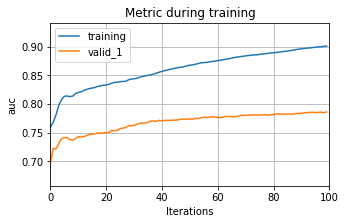

In [59]:
#評価指標の差
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)
print('[検証データ] acc: {:.4f}'.format(accuracy_score(y_va1, y_va1_pred)))
print('[ベースライン検証データ] acc: {:.4f}'.format(accuracy_score(y_va2, y_va2_pred)))

ax = lgb.plot_metric(model.evals_result_, metric='auc', figsize=(5, 3))

In [60]:
#後分類の分布
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))

print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[339  26]
 [ 73  42]]
[[0.70625    0.05416667]
 [0.15208333 0.0875    ]]
ベースライン検証データ
[[434  23]
 [ 93  50]]
[[0.72333333 0.03833333]
 [0.155      0.08333333]]


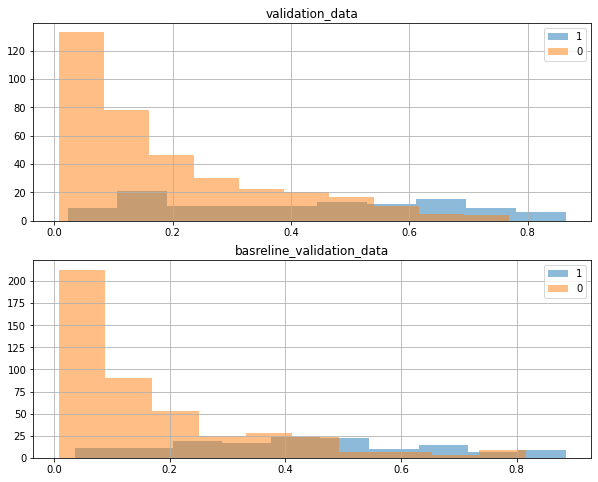

In [61]:
# 予測値の分布
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

fig = plt.figure(figsize=(10,8))

fig.add_subplot(2,1,1)
plt.title('validation_data')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

fig.add_subplot(2,1,2)
plt.title('basreline_validation_data')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

## チューニング

In [ ]:
import optuna

In [ ]:
# EDA後の特徴量
X_train = train[['DiabetesPedigreeFunction',
                 'BMI',
                 'Glucose',
                 'Age',
                 'Pregnancies',
                 'Pregnancies_bin',
                 'BloodPressure_na' ,
                 'BloodPressure_0', 
                 'SkinThickness',
                 'Insulin_0',
                 'Insulin_na',
                 
                 
                ]]
id_train = train[['index']]
y_train = train[['Outcome']]

In [ ]:
# 探索しないパラメータ

params_base = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metrics': 'auc',
    'learning_rate': 0.02,
    'n_estimators': 100000,
    'bagging_freq': 1,
    'seed': 123,
}
random_state=123

def objective(trial):
    # 探索するパラメータ
    params_tuning = {
        'num_leaves': trial.suggest_int('num_leaves',8,256),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',5,200),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-5, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-2, 1e2, log=True),
    }
    params_tuning.update(params_base)
    
    # モデル学習・評価
    list_metrics = []
    cv = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=random_state).split(X_train, y_train))
    for nfold in np.arange(4):
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
        x_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
        model = lgb.LGBMClassifier(**params_tuning)
        model.fit(x_tr,
                  y_tr,
                  eval_set=[(x_tr, y_tr), (x_va, y_va)],
                  early_stopping_rounds=100,
                  verbose=0,
                 )
        y_va_pred = model.predict_proba(x_va)[:,1]
        metric_va = accuracy_score(y_va, np.where(y_va_pred>0.5, 1, 0))
        list_metrics.append(metric_va)
        
    # 評価値の計算
    metrics = np.mean(list_metrics)
    
    return metrics

In [ ]:
sampler = optuna.samplers.TPESampler(seed=random_state)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=30)

In [ ]:
trial = study.best_trial
print('acc(best)={:.4f}'.format(trial.value))
display(trial.params)

In [ ]:
params_best = trial.params
params_best.update(params_base)
display(params_best)